In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import h5py
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.cluster import KMeans
from sklearn.preprocessing import *
import random
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
import scipy.sparse
import scipy.io
from scipy import * 
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

ModuleNotFoundError: No module named 'scanpy'

In [2]:
class RNA_seq_ae:
    
    def __init__(self, file, labels):
        self.ann = data_import_mtx(file, labels)
        self.data = self.ann.X
        
    def processed_data(self):
        return self.ann
        
        
    class Autoencoder(nn.Module):
        
        def __init__(self, data_length, hidden_dimension, bottleneck_dimension):
    
            super(RNA_seq_ae.Autoencoder, self).__init__()

            self.encoder = nn.Sequential(
            nn.Linear(data_length, hidden_dimension),
            nn.Softplus(),
            nn.Linear(hidden_dimension,bottleneck_dimension))
            
            self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dimension,hidden_dimension),
            nn.Softplus(),
            nn.Linear(hidden_dimension,data_length),
            nn.Tanhshrink())
            
            
        def forward(self, batch):
            batch = self.encoder(batch)
            batch = self.decoder(batch)
            return batch
        
        
    def train_test(self, bottleneck_size, batch_size, n_epochs,lr, hd1=None, hd2=None, deep=False):
        
            hidden_dimension = int(self.ann.shape[1]/2)
            
            batches = batchify_autoencoder(self.data, batch_size = batch_size)
            if deep:
                neural_network = RNA_seq_ae.Autoencoder_deep(len(np.ravel(self.data[0])), hd1, hd2,bottleneck_size)
            else:
                neural_network = RNA_seq_ae.Autoencoder(len(np.ravel(self.data[0])), hidden_dimension, bottleneck_size)
            optimizer = optim.Adagrad(neural_network.parameters(), lr=0.01)
            loss_function = nn.MSELoss()
            neural_network.train()
        
            for i in range(n_epochs):
                error = 0
                for ii in range(len(batches)):
                    optimizer.zero_grad()
                    batch = batches[ii]
                    predictions = neural_network(torch.tensor(np.asarray(batch).astype(np.float32)))
                    loss = loss_function(predictions,torch.tensor(np.asarray(batch).astype(np.float32)))       
                    loss.backward()      
                    optimizer.step()          
                    error += loss.data 
                    

            return neural_network

In [40]:
def data_import_mtx(ref_mtx, query_mtx, ref_labels):
    
        ref_data = sc.read_mtx(ref_mtx)
        ref_labels = pd.read_table(ref_labels, header = None)
        ref_data.obs['labels'] = np.array(labels[0])
        sc.pp.filter_cells(ref_data, min_genes = 200)
        sc.pp.filter_genes(ref_data, min_cells = 3)
        sc.pp.normalize_total(ref_data)
        sc.pp.scale(ref_data)

        query_data = sc.read_mtx(query_mtx)
        sc.pp.filter_cells(query_data, min_genes = 200)
        sc.pp.filter_genes(query_data, min_cells = 3)
        sc.pp.normalize_total(query_data)
        sc.pp.scale(query_data)

        ref_len = ref_data.obs.apply(len)
        query_len = query_data.obs.apply(len)

        if (ref_len > query_len):
            sc.pp.subsample(ref_data, n_obs=query_len)
        else:
            sc.pp.subsample(query_data, n_obs=ref_len)

        return ref_data, query_data
    
    
def batchify_autoencoder(query, ref, batch_size=16):
    
    batches= []
    for n in range(0, len(query),batch_size):
        if n+batch_size < len(query):
            batches.append(query[n:n+batch_size])
            batches.append(ref[n:n+batch_size])
            
    if len(data)%batch_size > 0:
        batches.append(query[len(query)-(len(query)%batch_size):len(query)])
        batches.append(ref[len(ref)-(len(ref)%batch_size):len(re)])
  
    return batches


def create_models(model, epochs):
    models = []
    model_num = 1
    for bot_size in range(4,11):
        m = model.train_test(bottleneck_size = bot_size,
                              batch_size = 32,
                              n_epochs = epochs,
                              lr = .01)
        models.append(m)
        print("finished model " + str(model_num) + " out of 7" )
        model_num += 1
   
    return models


def create_embeddings(model, ann):
    embeddings = model.encoder(torch.from_numpy(ann.X))
    em_df = pd.DataFrame()
    for col in range(embeddings.shape[1]):
        em_df["em_" + str(col+1)] = embeddings[:,col].detach().numpy()
        
    return em_df


def kmeans(embeddings, clusters, ann):
    fit = KMeans(n_clusters = clusters, random_state = 0).fit(embeddings)
    embeddings['k'] = fit.labels_
    embeddings['k'] = embeddings['k'].astype('category')
    embeddings['y'] = np.array(ann.obs['treatment'])
    return embeddings

def pca_nmi(comp, ann, clusters):
    pca = PCA(n_components = comp)
    fitting = pca.fit_transform(ann.X)
    principalDf = pd.DataFrame(data = fitting)
    kmeans = KMeans(n_clusters=clusters, random_state=0).fit(principalDf)
    principalDf['kmeans'] = kmeans.labels_
    principalDf['y'] = np.array(ann.obs['treatment'])
    nmi_score = nmi(principalDf.kmeans, principalDf.y)
    return nmi_score

def get_statistics(models, ann, clusters):
    stats = pd.DataFrame(columns=['comp', 'type', 'nmi'])
    for m in models:
        em = create_embeddings(m, ann)
        k_output = kmeans(em, clusters, ann)
        n = nmi(k_output.k, k_output.y)
        row = pd.DataFrame([[em.shape[1]-2, "ae", n]], columns=['comp', 'type', 'nmi'])
        stats = stats.append(row, ignore_index=True)
        
    for comp in range(4,13):
        row = pd.DataFrame([[comp, "pca", pca_nmi(comp, ann, clusters)]], columns=['comp', 'type', 'nmi'])
        stats = stats.append(row, ignore_index=True)
        
    return stats

In [10]:
zeisel = RNA_seq_ae("data/zeisel/sub_set-720.mtx", "data/zeisel/labels.txt")
zeisel_data = zeisel.processed_data()
mak = RNA_seq_ae("data/mak/sub_set-720.mtx", "data/mak/labels.txt")
mak_data = mak.processed_data()

In [11]:
z_epochs40 = create_models(zeisel, 50)
mak_epochs40 = create_models(mak, 50)

finished model 1 out of 7
finished model 2 out of 7
finished model 3 out of 7
finished model 4 out of 7
finished model 5 out of 7
finished model 6 out of 7
finished model 7 out of 7
finished model 1 out of 7
finished model 2 out of 7
finished model 3 out of 7
finished model 4 out of 7
finished model 5 out of 7
finished model 6 out of 7
finished model 7 out of 7


In [36]:
stats_mak = get_statistics(mak_epochs40, mak_data, 39)
stats_zeisel = get_statistics(z_epochs40, zeisel_data, 9)

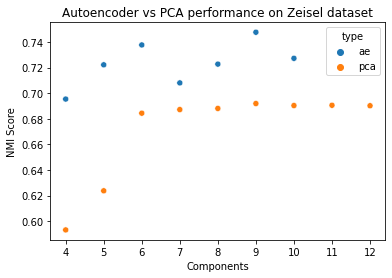

In [37]:
z_plot = sns.scatterplot(x = 'comp', y='nmi', hue='type', data = stats_zeisel)\
    .set(title = "Autoencoder vs PCA performance on Zeisel dataset",
         xlabel = "Components",
         ylabel = "NMI Score")

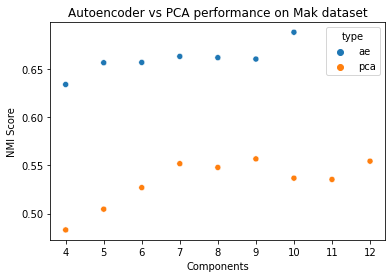

In [38]:
m_plot = sns.scatterplot(x = 'comp', y='nmi', hue='type', data = stats_mak)\
    .set(title = "Autoencoder vs PCA performance on Mak dataset",
         xlabel = "Components",
         ylabel = "NMI Score")

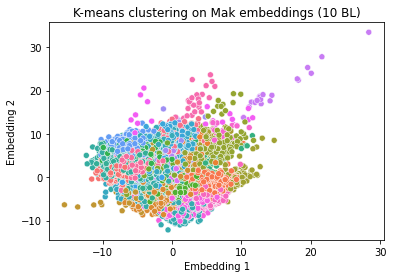

In [55]:
kz = kmeans(create_embeddings(mak_epochs40[6], mak_data), ann=mak_data, clusters=39)
g = sns.scatterplot(x="em_1", y="em_2", hue="k", data=kz, legend=False)\
    .set(title="K-means clustering on Mak embeddings (10 BL)",
        xlabel = "Embedding 1",
        ylabel="Embedding 2")

kz.y = kz.y.astype('int').astype('category')

[Text(0.5, 1.0, 'Ground Truth for Mak (10 BL)'),
 Text(0.5, 0, 'Embedding 1'),
 Text(0, 0.5, 'Embedding 2')]

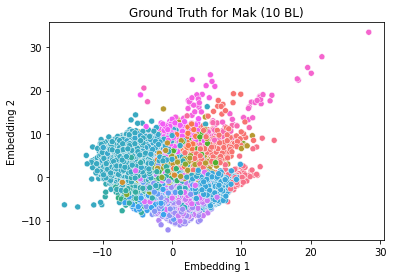

In [58]:
sns.scatterplot(x="em_1", y="em_2", hue="y", data=kz, legend=False)\
    .set(title="Ground Truth for Mak (10 BL)",
        xlabel = "Embedding 1",
        ylabel="Embedding 2")

In [561]:
stats_50 = get_statistics(models, zeisel_processed_data)
stats_5 = get_statistics(models_5, zeisel_processed_data)
stats_10 = get_statistics(models_10, zeisel_processed_data)
stats_100 = get_statistics(models_100, zeisel_processed_data)

In [562]:
stats_5.loc[stats_5.type == "ae", "type"] = "ae_5"
stats_10.loc[stats_10.type == "ae", "type"] = "ae_10"
stats_50.loc[stats_50.type == "ae", "type"] = "ae_50"
stats_100.loc[stats_100.type == "ae", "type"] = "ae_100"
stats = pd.concat([stats_5, stats_10, stats_50, stats_100])

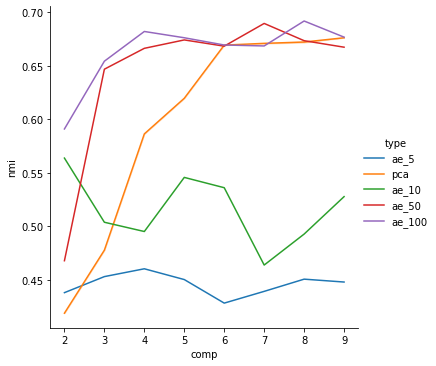

In [563]:
sns.relplot(x='comp', y='nmi', hue='type', data=stats, kind='line')

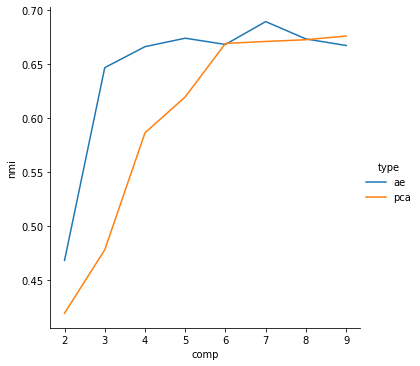

In [505]:
sns.relplot(x='comp', y='nmi', hue='type', data=stats_50, kind='line')

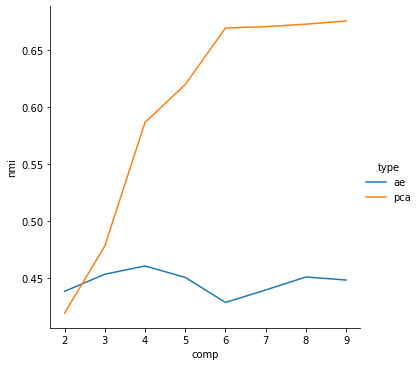

In [513]:
sns.relplot(x='comp', y='nmi', hue='type', data=stats_5, kind='line')

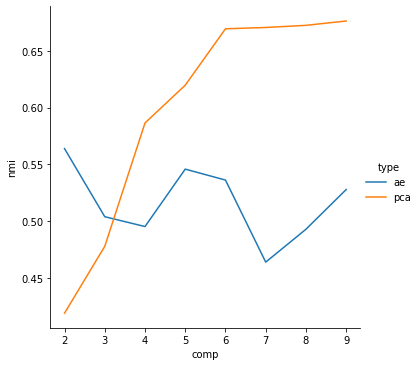

In [515]:
sns.relplot(x='comp', y='nmi', hue='type', data=stats_10, kind='line')

In [542]:
zeisel_processed_data.X.shape

(2994, 720)

In [548]:
embeddings = create_embeddings(models_100[2], zeisel_processed_data)

In [551]:
final = kmeans(embeddings, 10, zeisel_processed_data)

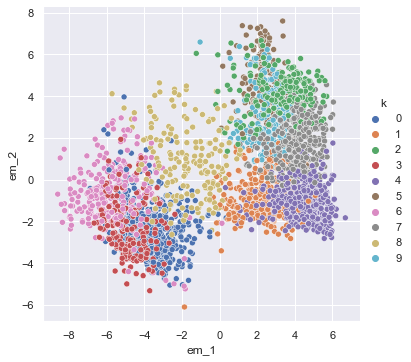

In [568]:
sns.relplot(x="em_1", y="em_2", hue="k", data = final)

In [556]:
final.k = final.k.astype('category')